--2024-12-19 02:42:56--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  9.46MB/s    in 21s     

2024-12-19 02:43:17 (11.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-12-19 02:43:18--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

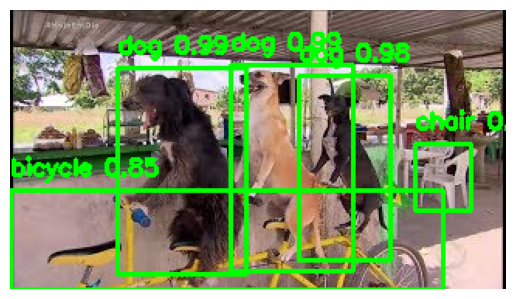

In [2]:
# Etapa 1: Configuração do ambiente no Google Colab
!pip install opencv-python-headless matplotlib

# Baixar os arquivos necessários do YOLO
!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names

# Importando as bibliotecas necessárias
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Carregar a rede YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Carregar os nomes das classes
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Configuração da saída
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Carregar a imagem
image_path = "/content/mqdefault.jpg"
image = cv2.imread(image_path)
height, width, _ = image.shape

# Pré-processamento da imagem
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

# Inferência
outs = net.forward(output_layers)

# Processamento das detecções
class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Ajuste o limite de confiança
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Coordenadas do retângulo
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Aplicar supressão não máxima
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Desenhar as caixas na imagem
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]
        color = (0, 255, 0)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Salvar e exibir a imagem com as detecções
cv2.imwrite("predictions.jpg", image)

# Mostrar a imagem no Google Colab
img_result = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img_result)
plt.axis("off")
plt.show()
